# INIT

## Import and load the original data

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator
from utils.master_generator import MasterGenerator
from utils.cluster_generator import ClusterGenerator

from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, log_loss
from sklearn.metrics import make_scorer
import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.naive_bayes import GaussianNB
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense
import prince
import numpy as np

c:\Users\Barak\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = Loader.load_by_fueltype("Eléctrico")
label_encoder = LabelEncoder()
data["price_categ"].value_counts()

d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
d:\Código\ProyectoML\Cars_Price_Prediction\Trees\..\utils\loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  mer

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

### Describe some columns
A more detailed version of the dataset can be found in the DataDescription.ipynb

In [3]:
data.select_dtypes(include=['category'])

,color,brand,model,version,fuelType,bodyTypeId,transmissionTypeId,province,environmentalLabel,jato_classification,...,Acabado Exterior_Pintura,Acabado Exterior_Rueda,AC_Zones,AC_Type,Metodo_Apertura,Tipo_Faro,interior_clock,arm_suppport_front,arm_suppport_back,price_categ
idx,,,,,,,,,,,,,,,,,,,,,
3,Rosa,FIAT,500,laPrima 31 320km 85kW 118CV,Eléctrico,Berlina,Automatico,Barcelona,0,L1,...,pintura metalizada,no tiene,MONOZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,no tiene,Middle range
7,Blanco (Serenity white),HYUNDAI,Kona,EV 115kW 48kWh Flexx,Eléctrico,SUV,Automatico,Barcelona,0,M1,...,pintura solida,no tiene,BIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Middle high range
10,Blanco,RENAULT,Kangoo Furgon,L1 Start EV45 22kW,Eléctrico,Furgoneta,Automatico,Asturias,NaN,B1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Middle high range
14,Azul,PEUGEOT,e-208,Allure Electrico 136 100 Kw,Eléctrico,Berlina,Automatico,Valencia,NaN,M4,...,pintura metalizada,no tiene,MONOZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,no tiene,Middle range
18,Gris / Plata,AUDI,e-tron GT,RS quattro 440kW 598CV,Eléctrico,Berlina,Automatico,Vizcaya,0,B1,...,pintura solida,no tiene,TRIZONA,AUTO,Tarjeta/llave inteligente,LED,no tiene,Tiene,Tiene,Luxury
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164732,Blanco (White Silver),MINI,MINI,COOPER SE,Eléctrico,Berlina,Automatico,Albacete,0,M2,...,pintura metalizada,no tiene,BIZONA,AUTO,Mando a distancia,LED,no tiene,Tiene,no tiene,Middle range
164840,Negro,SMART,fortwo,60kW81CV EQ coupe,Eléctrico,Berlina,Automatico,Madrid,0,B1,...,pintura negra,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Budget
164991,Negro,SMART,fortwo,60kW81CV electric drive coupe,Eléctrico,Berlina,Automatico,Zaragoza,0,B1,...,pintura solida,no tiene,MONOZONA,AUTO,Mando a distancia,Otro,no tiene,no tiene,no tiene,Budget


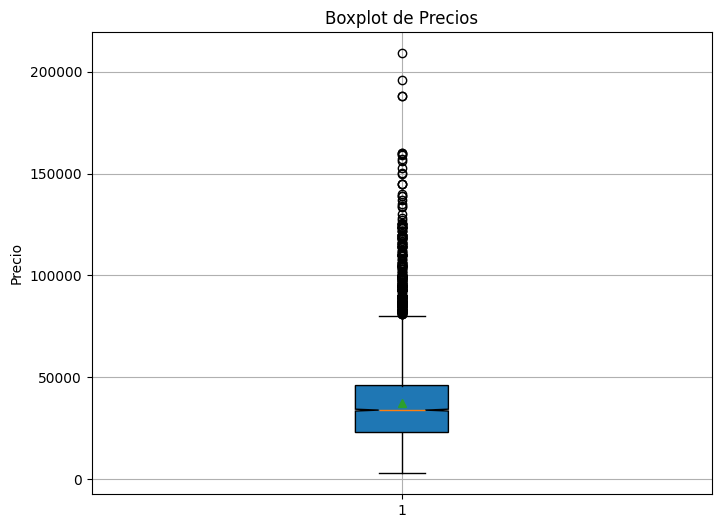

In [4]:
precios_electricos = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_electricos, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

The related outliers were checked manually throught the data source, and we could confirmed that they are not outliers

In [5]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)  # Esta es la mediana
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["fuelType"] == "Eléctrico"][data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)

80525.0


,price,brand
idx,,
28269,209000,MASERATI
85726,196000,MASERATI
144182,188000,MERCEDES-BENZ
134773,188000,MERCEDES-BENZ
21981,159900,PORSCHE
...,...,...
1917,81400,MERCEDES-BENZ
28058,80900,AUDI
134254,80900,MERCEDES-BENZ


# Electric cars

## Numerical variables selection Eléctrico
Here we will perform PCA and use correlation matrix to select the most correlated numerical variables

In [6]:
def fill_electric_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    #fill the elemental columns that has a minor amount of missing data with the mode
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.length")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "dimensions.height")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.maximumBatteryKWH_kWh")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.onboardCharger_kW")
    numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, "electricFeatures.range_KM")

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "power_kw", "dimensions.length", "dimensions.height", "dimensions.width"], y_column="electricFeatures.combinedConsumption_kWh/")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["electricFeatures.maximumBatteryKWH_kWh", "electricFeatures.combinedConsumption_kWh/", "power_kw"], y_column="electricFeatures.range_KM")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_electric_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])
    numerical_columns.drop(columns=[ "car_id", "electricFeatures.maxPower_CV"], inplace=True) # electricFeatures.maxPower_CV is = power_cv (Duplicated colums)

    #if all the values of the numerical columns is 0, we remove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)

    #Remove the column with all NAs
    max_nans = 6586
    thresh = numerical_columns.shape[0] - max_nans

    numerical_columns.dropna(axis=1, thresh=thresh+1, inplace=True)
    return fill_electric_numerical_columns(numerical_columns)

In [7]:
numerical_columns = get_electric_numerical_columns(data)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6468475373043994%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 16.91508204296949%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 5.689473571028928%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 13.035625391285748%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 11.85488371952156%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 17.854083487783583%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'power_kw', 'dimensions.length', 'dimensions.height', 'dimensions.width'] -> electricFeatures.combinedConsumption_kWh/: 17.20475510968712%
Regression mape ['electricFeatures.maximumBatteryKWH_kWh', 'electricFeatures.combinedConsumption_kWh/', 'power_kw'] -> electricFeatures.range_KM: 16.16138222681962%


In [8]:
correlation_matrix = numerical_columns.corr()["price"]
print(correlation_matrix)

price                                        1.000000
km                                          -0.343331
year                                         0.459700
doors                                        0.092279
seatingCapacity                              0.257532
trunkCapacityInLiters                        0.301739
maxSpeed                                     0.655830
acceleration                                -0.582307
power_cv                                     0.709338
power_kw                                     0.712126
max_torque_nm                                0.677488
speakers                                     0.294090
dimensions.width                             0.689372
dimensions.height                            0.055209
dimensions.length                            0.613427
Numero_Testigos                              0.183137
Llantas_Diametro_cm                          0.633856
electricFeatures.range_KM                    0.600411
electricFeatures.maximumBatt

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

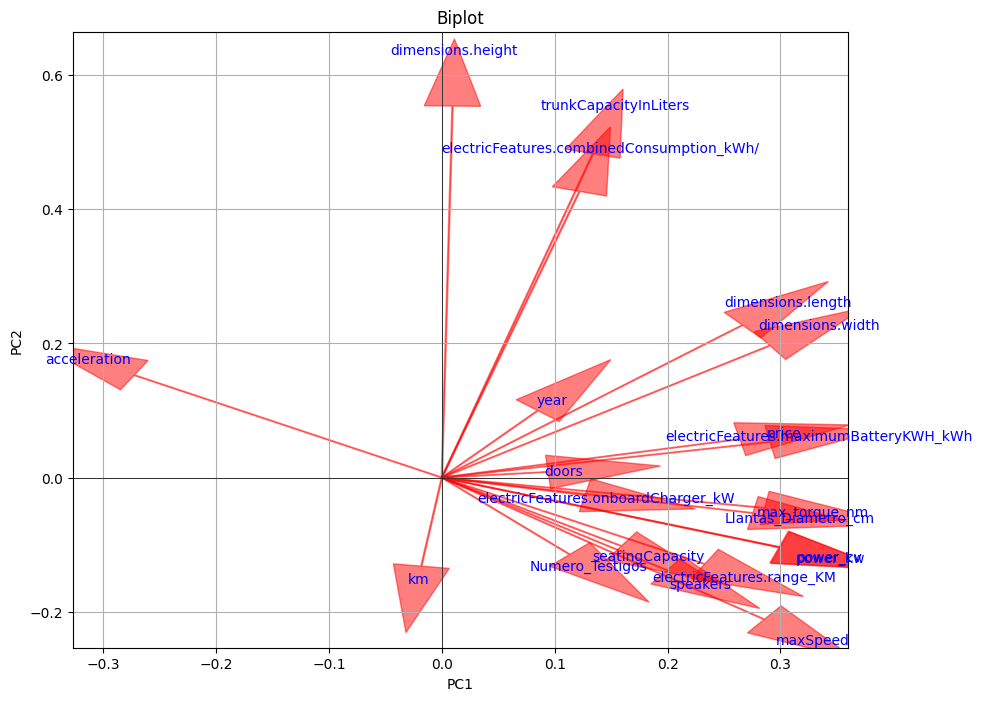

In [10]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

In [11]:
numerical_columns.drop(columns=["Numero_Testigos", "dimensions.height", "doors", "electricFeatures.onboardCharger_kW", "seatingCapacity"], inplace=True)

## Test CART regression trees with only numerical variables

In [12]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

MAE: 3857.3197413518574 
 MSE: 51026135.07536308 
 RMSE: 7143.258015455068 
 R2: 0.8916782472245633 
 MAPE: 10.555081896713386
Mean: 3857.3197413518574
Variance: 36147219.48834031
Standard Deviation: 6012.2557736959525


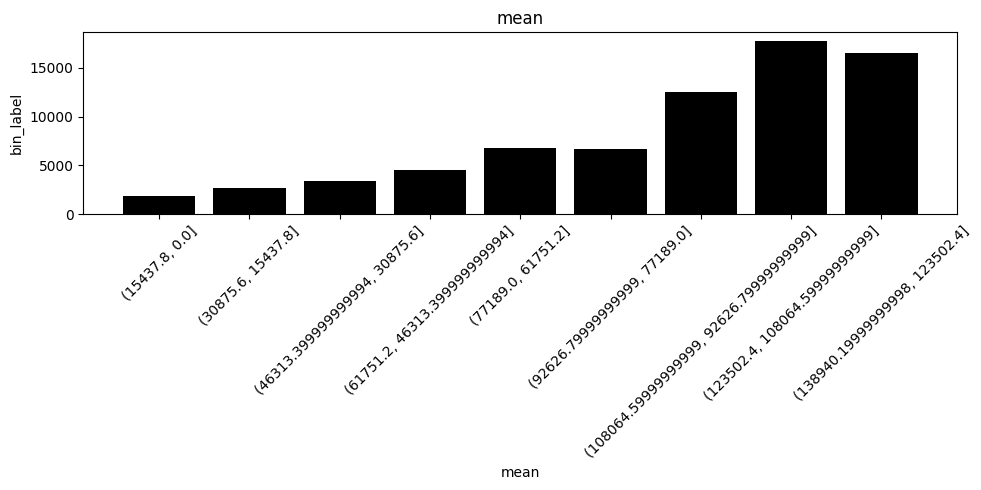

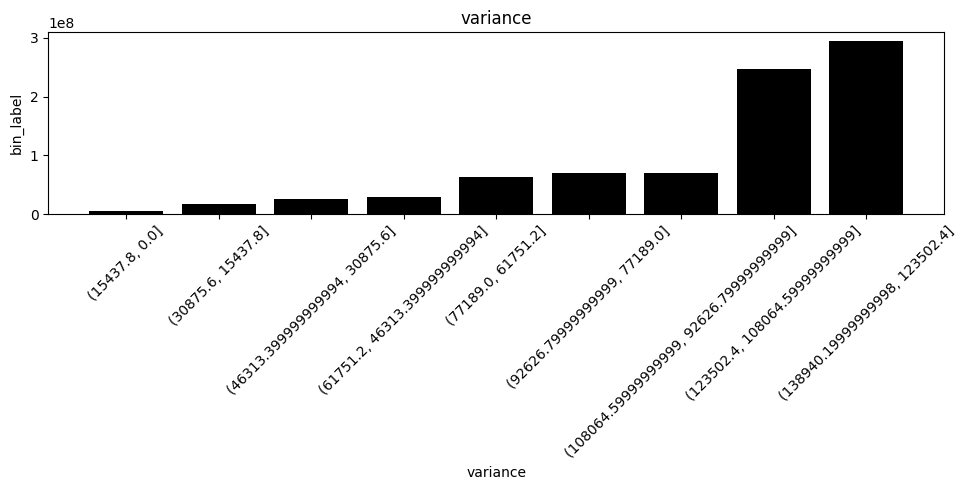

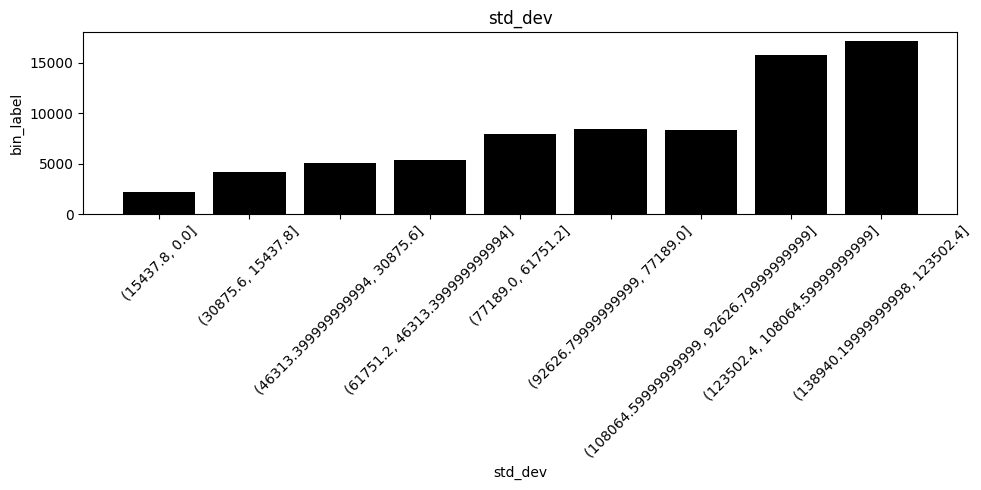

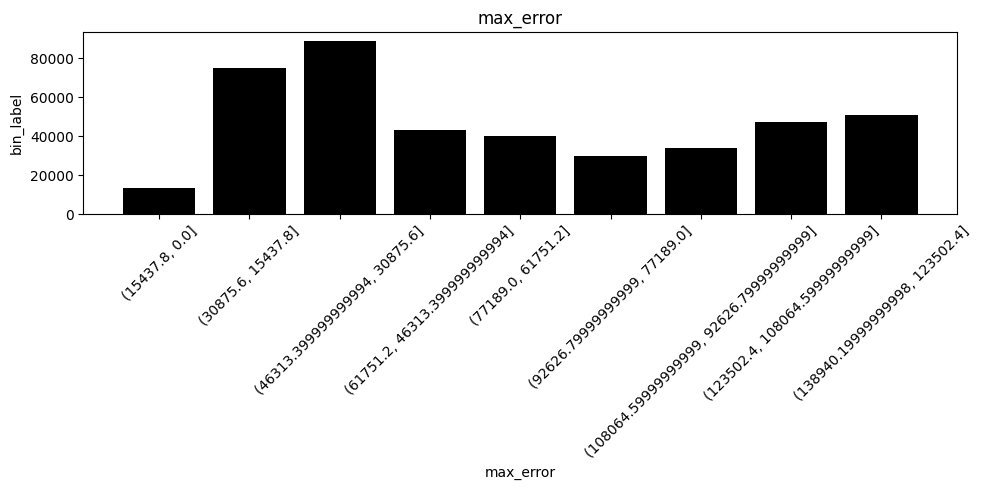

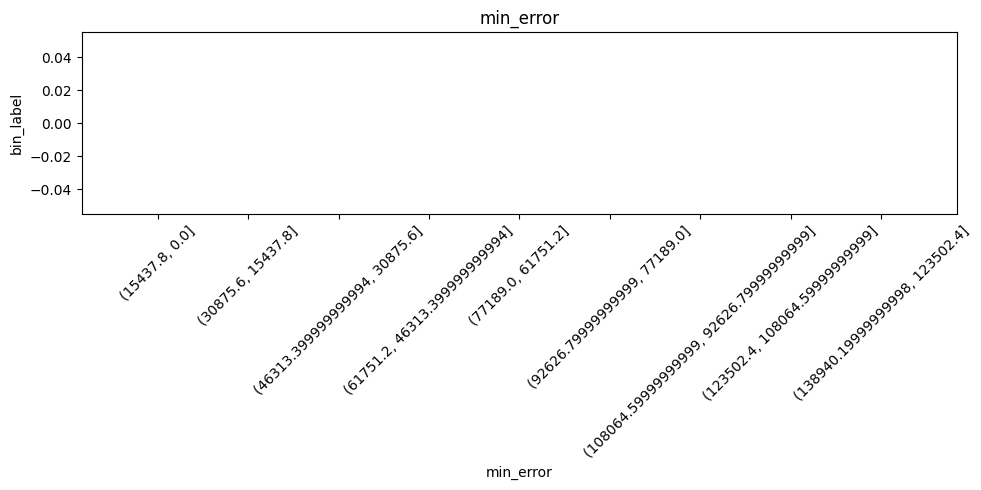

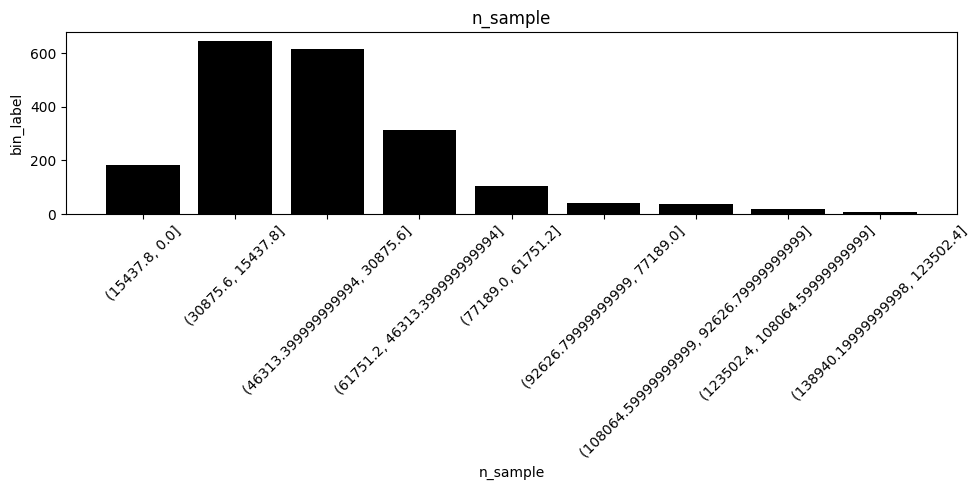

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(15437.8, 0.0]",1850.796196,4.866141e+06,2205.933235,13300.0,0.0,184
1,"(30875.6, 15437.8]",2647.697884,1.760443e+07,4195.763073,74990.0,0.0,646
2,"(46313.399999999994, 30875.6]",3419.563818,2.523401e+07,5023.346319,88910.0,0.0,615
3,"(61751.2, 46313.399999999994]",4477.662143,2.889077e+07,5375.013117,43400.0,0.0,314
4,"(77189.0, 61751.2]",6821.641210,6.350576e+07,7969.050421,39910.0,0.0,106
5,"(92626.79999999999, 77189.0]",6709.316722,7.039283e+07,8390.043442,29600.0,0.0,43
6,"(108064.59999999999, 92626.79999999999]",12553.082051,7.030372e+07,8384.731179,34000.0,0.0,39
7,"(123502.4, 108064.59999999999]",17739.444444,2.474880e+08,15731.751853,47300.0,0.0,18
8,"(138940.19999999998, 123502.4]",16504.111111,2.946817e+08,17166.295943,51010.0,0.0,6


In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test, plot= True, bins=10)

## Electrico categorical variables
Here we will perform CA and Chi2 test to select the best categorical variables

In [14]:
def get_electric_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    ret = df.select_dtypes(include=['category'])
    ret = ret.drop(columns=["environmentalLabel"]) #All of the cars of this dataframes are electrical which implies 0 emission
    ret = Data_processor.remove_redundand_columns(ret)
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="version")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model"], Y="jato_classification")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction"], Y="brakes")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    ret = Data_processor.impute_categorical_mode(df=ret, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    return ret

In [15]:
categorical_columns = get_electric_categorical_columns(data)
print("\nCategorical Columns Index:")
print(categorical_columns.index)

Number of missing values in 'version' before filling with 'unknown': 1
Number of missing values in 'jato_classification' before filling with 'unknown': 0
Number of missing values in 'brakes' before filling with 'unknown': 0
Number of missing values in 'front_suspension' before filling with 'unknown': 0
Number of missing values in 'rear_suspension' before filling with 'unknown': 4

Categorical Columns Index:
Index([     3,      7,     10,     14,     18,     47,     56,     61,     65,
           66,
       ...
       164218, 164219, 164220, 164240, 164731, 164732, 164840, 164991, 165059,
       165299],
      dtype='int64', name='idx', length=6591)


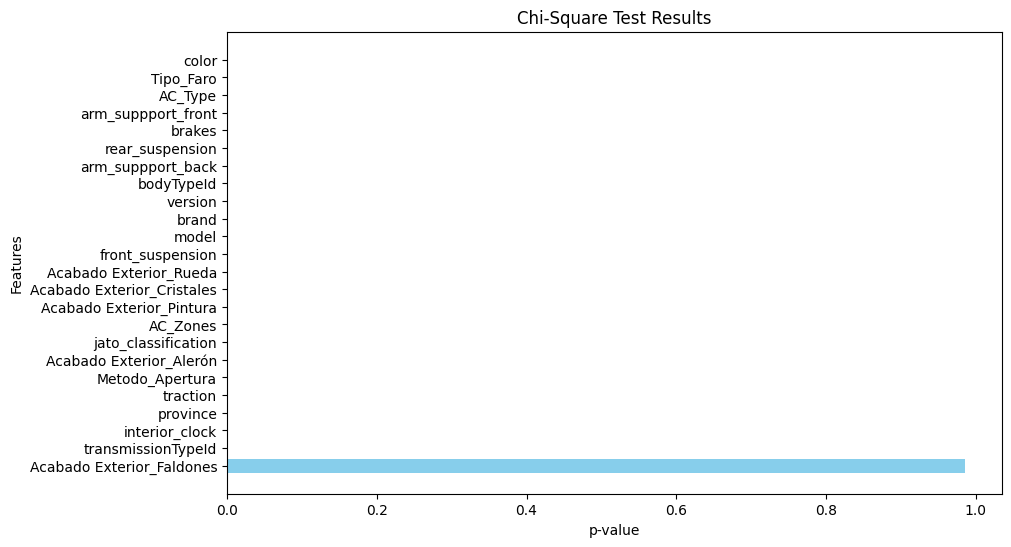

,Feature,Chi2 Stat,p-value
0,color,17355.917738,0.000000e+00
20,Tipo_Faro,1590.069687,0.000000e+00
18,AC_Type,1486.737498,0.000000e+00
22,arm_suppport_front,3759.181818,0.000000e+00
9,brakes,1581.335781,0.000000e+00
11,rear_suspension,1848.387572,0.000000e+00
23,arm_suppport_back,2401.453330,0.000000e+00
4,bodyTypeId,6530.816750,0.000000e+00
3,version,19903.204434,0.000000e+00
1,brand,1800.198086,0.000000e+00


In [16]:
Data_processor.chi_square_test(categorical_columns=categorical_columns, column_y="price_categ")

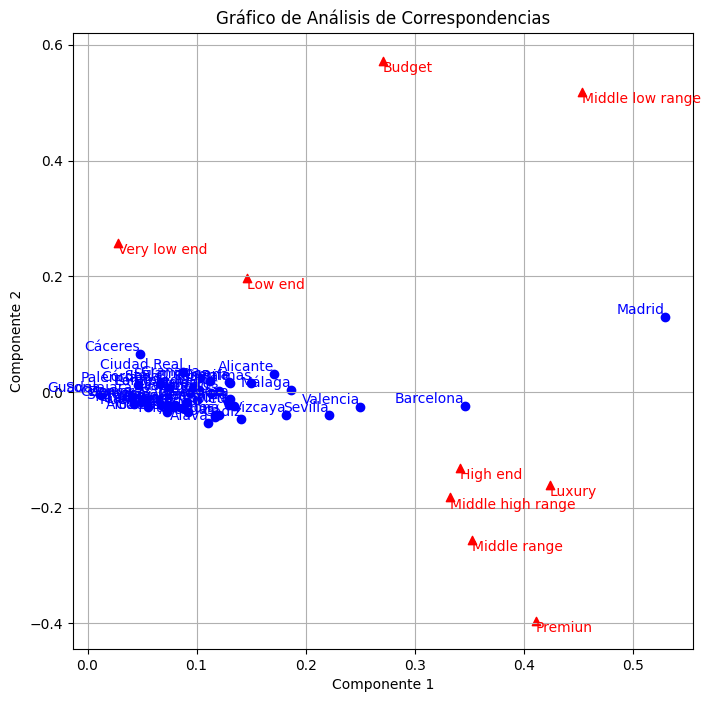

In [17]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [18]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     1353
Luxury               1182
Premiun              1113
Middle range          820
High end              767
Middle high range     727
Budget                483
Low end               141
Very low end            5
Name: count, dtype: int64

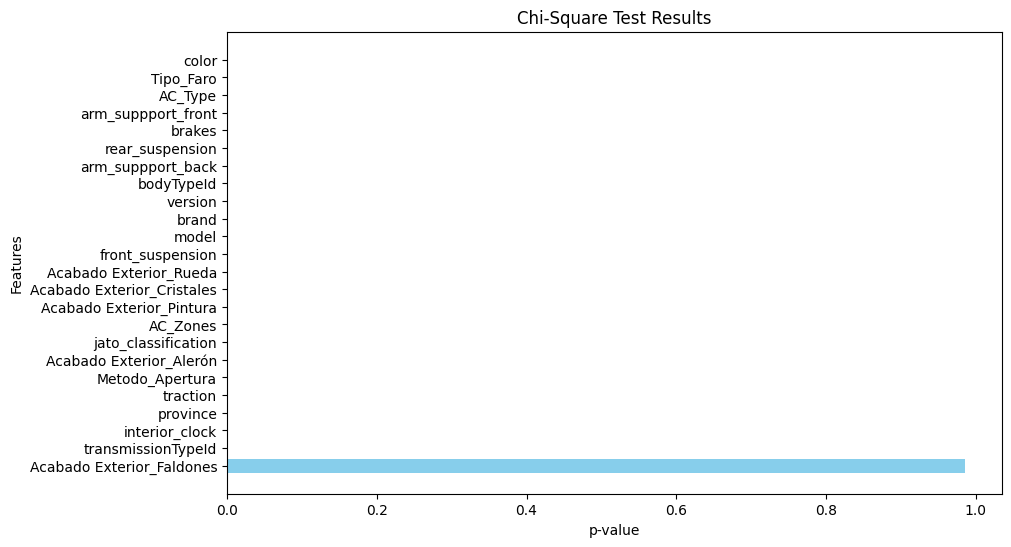

Index(['color', 'Tipo_Faro', 'AC_Type', 'arm_suppport_front', 'brakes',
       'rear_suspension', 'arm_suppport_back', 'bodyTypeId', 'version',
       'brand', 'model', 'price_categ'],
      dtype='object')

In [19]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

## Test CART tree classifier with only categorical values

In [20]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)


In [21]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
34583,Luxury,Luxury,0
151019,Middle high range,High end,1
40752,Luxury,Luxury,0
13609,Middle high range,High end,1
68390,Budget,Budget,0
...,...,...,...
66387,Luxury,Luxury,0
7560,High end,Middle range,2
25347,Premiun,Luxury,1


In [22]:
# Calcular la precisión
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6486349848331648 
 Precision: 0.6464064291648314 
 Recall: 0.6486349848331648 
 F1 Score: 0.6466753628567222
Confusion Matrix:
 [[302   0   1   0  14  27  37   0   0]
 [  6  95   0   6  41   0  27  40   0]
 [  1   1  26   0   1  12   1   0   1]
 [  0   8   0 323   4   0   0  58   0]
 [ 22  38   0   0  94   0  46  14   0]
 [ 37   0  15   0   0  81   0   0   0]
 [ 63  13   1   1  29   0 137   4   0]
 [  1  43   0  56  20   0   6 225   0]
 [  0   0   0   0   0   0   0   0   0]]


c:\Users\Barak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


We can verify that the prediction is not very accurate but we need to know how big is the error.

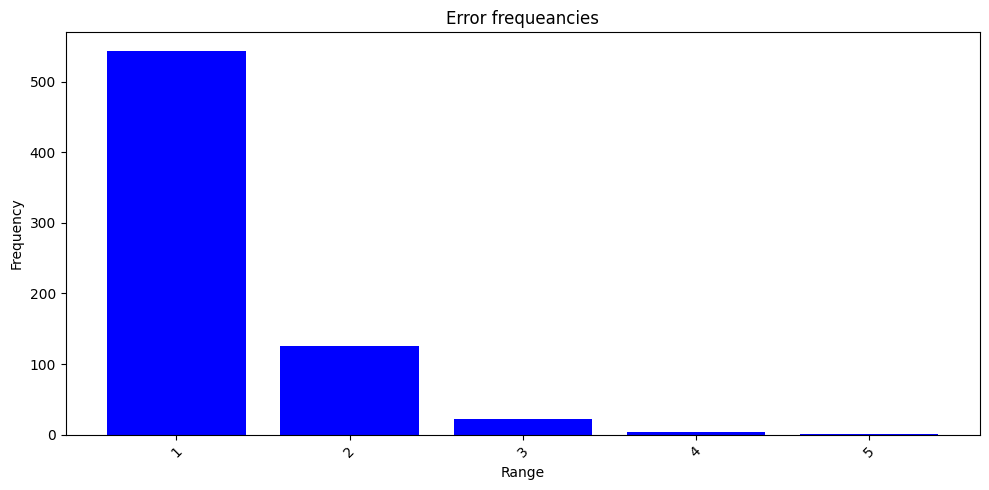

{1: 543, 2: 126, 3: 22, 4: 3, 5: 1}
Error mean: 1.2633093525179857
Error rate: 35.136501516683516 %
Overall mean: 0.44388270980788674


In [23]:
Evaluator.eval_ordinal_classification (result["diff"])

Even having errors, we can verify that the errors are not that big

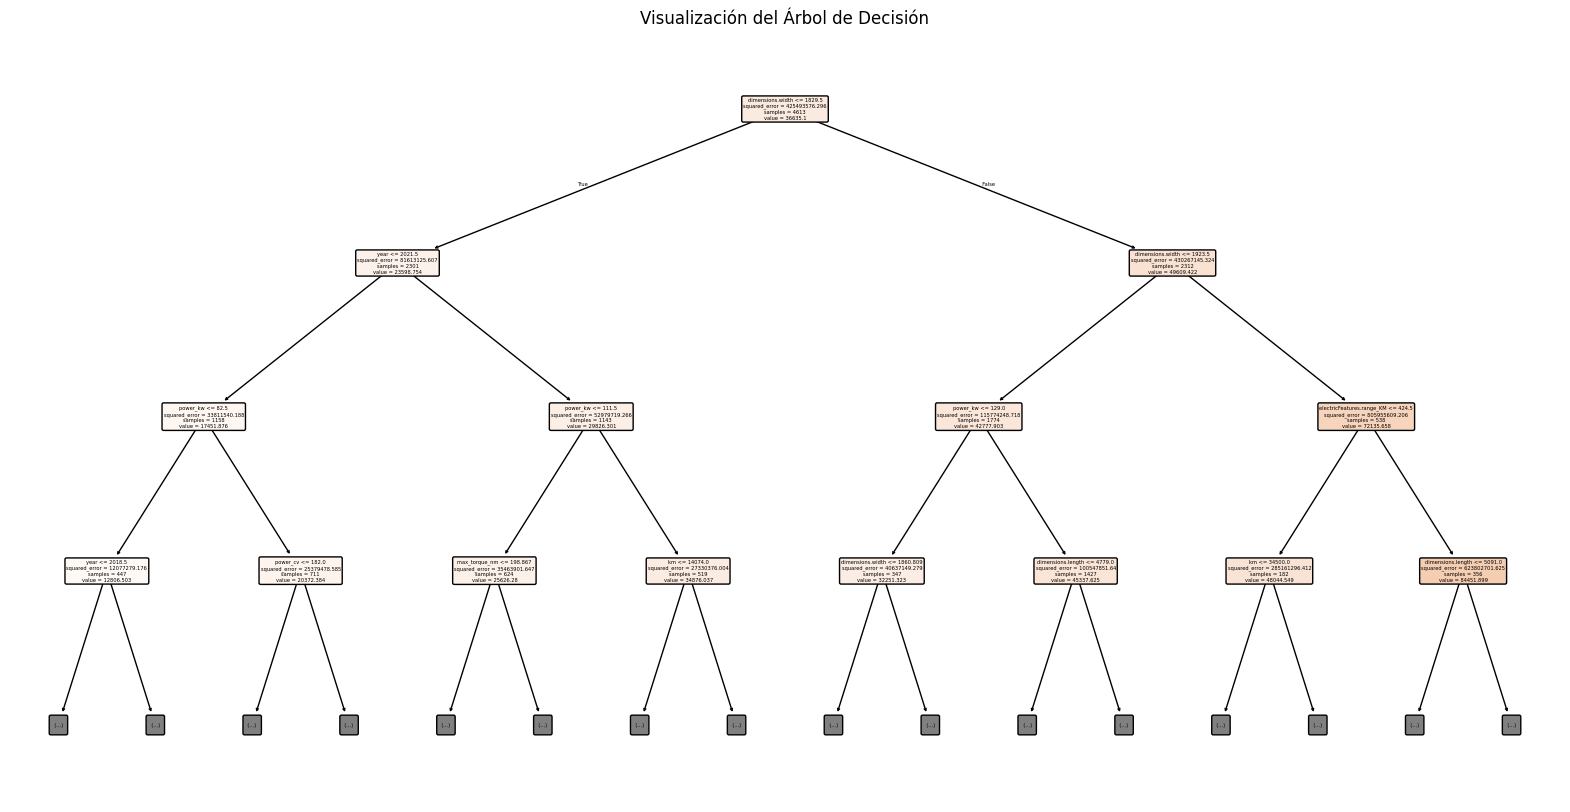

In [24]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

# Agorithms evaluation

In [25]:
electric_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how='inner')
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)
print(electric_cars.shape)
target = electric_cars[["price", "price_categ"]]
electric_cars.drop(columns=["price", "price_categ"], inplace=True)


numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

encoders_and_scalers = {}
for column in numerical_column_names:
    scaler = StandardScaler()
    electric_cars[[column]] = scaler.fit_transform(electric_cars[[column]])
    encoders_and_scalers[column] = scaler 

electric_cars_encoded = pd.get_dummies(electric_cars, columns=categorical_column_names)
print(electric_cars_encoded.shape)

(6591, 28)
(6591, 9182)


## Classification

In [26]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [27]:
from sklearn.model_selection import cross_val_score


def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    else:  Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)
    cv_scores = cross_val_score(classifier, X_test, y_test, cv=5, scoring='accuracy')
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")




### CART

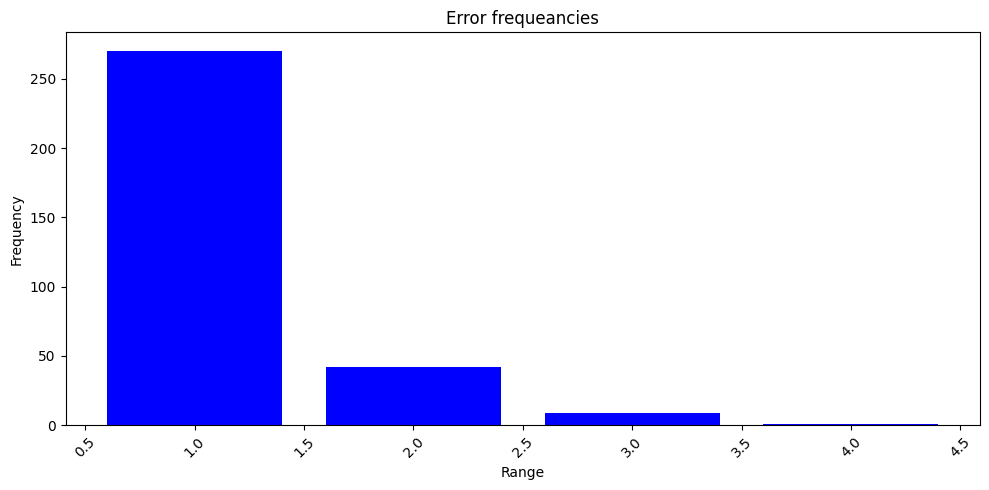

{1: 270, 2: 42, 3: 9, 4: 1}
Error mean: 1.1956521739130435
Error rate: 16.27906976744186 %
Overall mean: 0.008088978766430738
Accuracy: 0.6905965621840243 
 Precision: 0.688289397489699 
 Recall: 0.6905965621840243 
 F1 Score: 0.688943628730503
Confusion Matrix:
 [[100   0   9   0   0  24   0   0   0]
 [  0 111   0   7  42   0  18  37   0]
 [ 12   1  25   0   0   3   0   0   2]
 [  0   3   0 343   1   0   1  45   0]
 [  0  28   0   5 109  12  47  13   0]
 [ 21   0   1   0  17 310  31   1   0]
 [  0  12   0   0  39  55 137   5   0]
 [  0  49   0  55   8   0   8 231   0]
 [  0   0   0   0   0   0   0   0   0]]


c:\Users\Barak\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


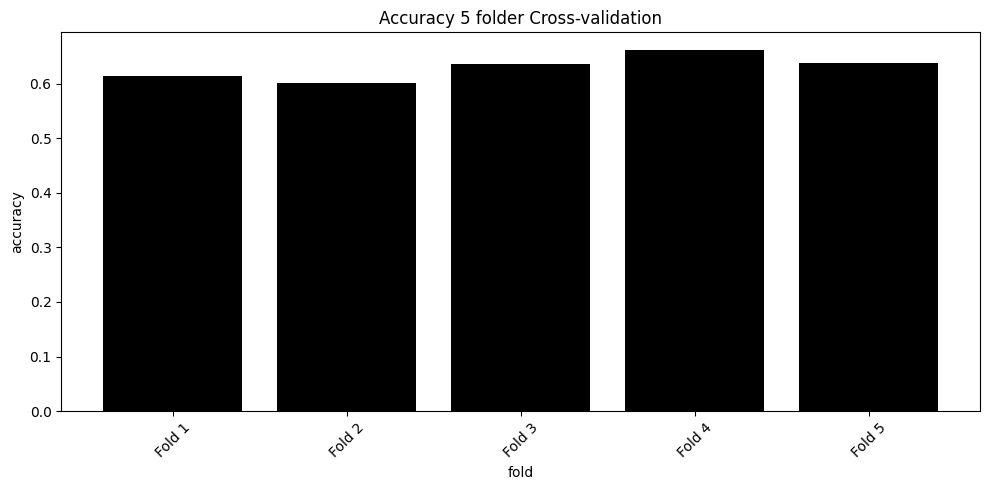

In [28]:
classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42), classifier_name="CART")

### Random forest
Random forest can get a better result at a higher computational time cost

In [29]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

KeyboardInterrupt: 

### SVM
Much higher computational cost, more distributed error, but in overall worse result

In [ ]:
classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive bayes

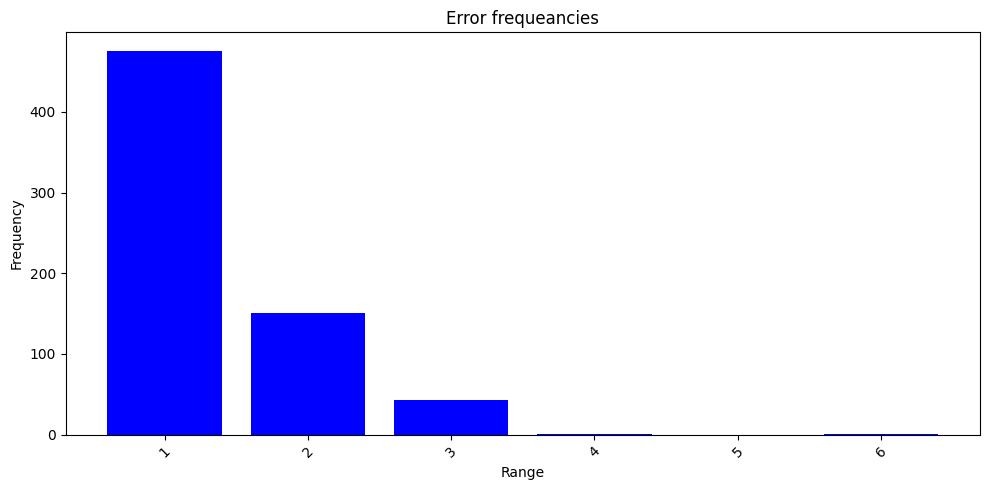

{np.int64(1): np.int64(475), np.int64(2): np.int64(151), np.int64(3): np.int64(43), np.int64(4): np.int64(1), np.int64(6): np.int64(1)}
Error mean: 1.3651266766020864
Error rate: 33.92315470171891 %
Overall mean: 0.2724974721941355
Accuracy: 0.4903943377148635 
 Precision: 0.5989652176963056 
 Recall: 0.4903943377148635 
 F1 Score: 0.479325150387945
Confusion Matrix:
 [[ 75   0  41   0   0   8   1   0   8]
 [  0  72   0   3  99   1  33   7   0]
 [  6   0  28   0   1   1   1   0   6]
 [  0  27   0 323  24   0   1  18   0]
 [  2  16   0   1 111   1  81   2   0]
 [ 94   0  15   0  22  91 157   0   2]
 [  8   2   1   0  37  11 188   1   0]
 [  0 125   1  71  59   0  13  82   0]
 [  0   0   0   0   0   0   0   0   0]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


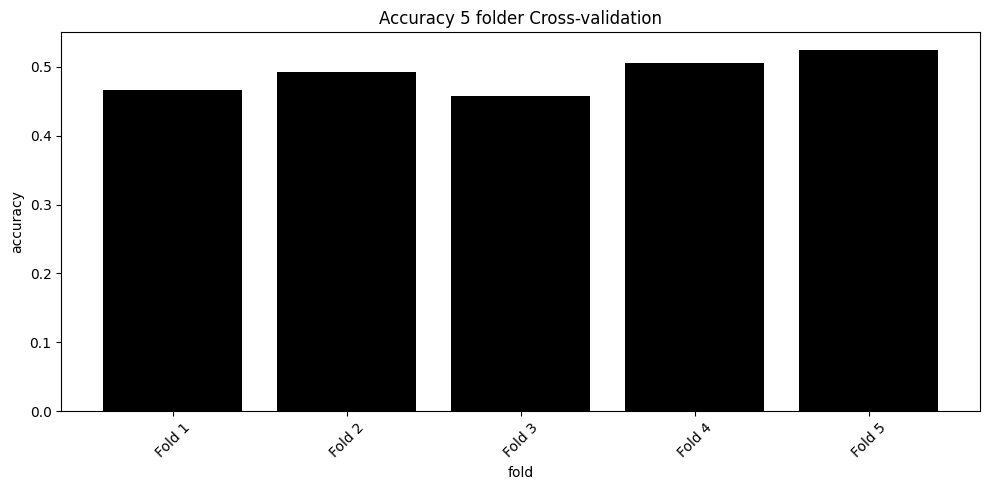

In [31]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes")

### ANN

In [32]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    electric_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3600 - loss: 1.7859 - val_accuracy: 0.6112 - val_loss: 1.0304
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7339 - loss: 0.8164 - val_accuracy: 0.6603 - val_loss: 0.9352
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7776 - loss: 0.6119 - val_accuracy: 0.6613 - val_loss: 0.9340
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7973 - loss: 0.5220 - val_accuracy: 0.6608 - val_loss: 0.9477
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8009 - loss: 0.5134 - val_accuracy: 0.6648 - val_loss: 0.9589
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8102 - loss: 0.4590 - val_accuracy: 0.6663 - val_loss: 0.9674
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8081 - loss: 0.4541 - val_accuracy: 0.6623 - val_loss: 0.9736
Epoch 8/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8151 - loss: 0.4370 - val_accuracy: 0.6729 - 

In [33]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


In [34]:
Evaluator.eval_classification(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

Accuracy: 0.6799797775530839 
 Precision: 0.6795877549181433 
 Recall: 0.6799797775530839 
 F1 Score: 0.6791374162787738
Confusion Matrix:
 [[ 91   0  13   0   0  27   0   0   2]
 [  0 117   0   3  41   4  15  35   0]
 [ 14   0  25   0   1   1   0   0   2]
 [  0   3   0 346   1   0   0  43   0]
 [  1  44   0   2 105  11  42   9   0]
 [ 26   1   2   0  17 301  33   1   0]
 [  0  10   0   0  38  56 138   6   0]
 [  2  50   0  60  11   2   4 222   0]
 [  0   0   0   0   0   0   0   0   0]]


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Regression

In [30]:
X_train, X_test, y_train, y_test = train_test_split(electric_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [31]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="MAPE")

### Cart

MAE: 3704.455760989937 
 MSE: 47039770.681603834 
 RMSE: 6858.554562121952 
 R2: 0.9001407729027444 
 MAPE: 10.077983068173689
Mean: 3704.455760989937
Variance: 33316778.1964723
Standard Deviation: 5772.068796928213
r2_adjusted: 1.0274006512104474


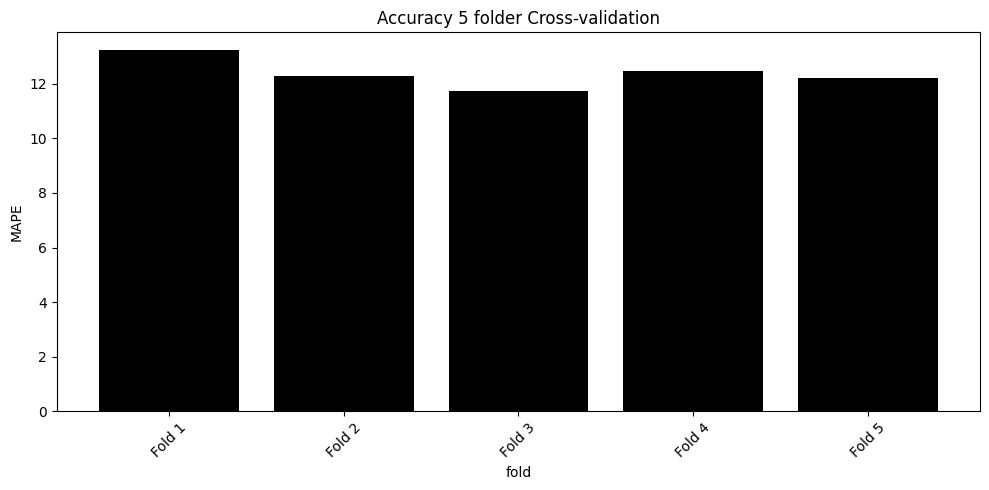

In [32]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### RandomForest

MAE: 3039.8188266309726 
 MSE: 26435981.22778793 
 RMSE: 5141.593257715737 
 R2: 0.9438798996102067 
 MAPE: 8.252912485802883
Mean: 3039.8188266309726
Variance: 17195482.72904783
Standard Deviation: 4146.743629530023
r2_adjusted: 1.0153989505163943


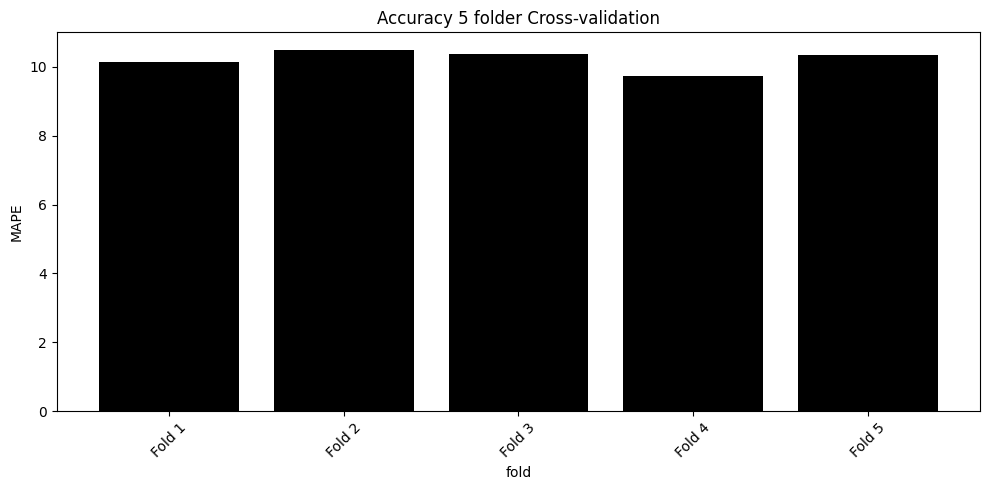

In [33]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

MAE: 14874.279524279793 
 MSE: 468021046.0168664 
 RMSE: 21633.794073552293 
 R2: 0.0064530663460306 
 MAPE: 46.17115117841719
Mean: 14874.279524279793
Variance: 246776854.65045726
Standard Deviation: 15709.132842090847
r2_adjusted: 1.2726221079575153


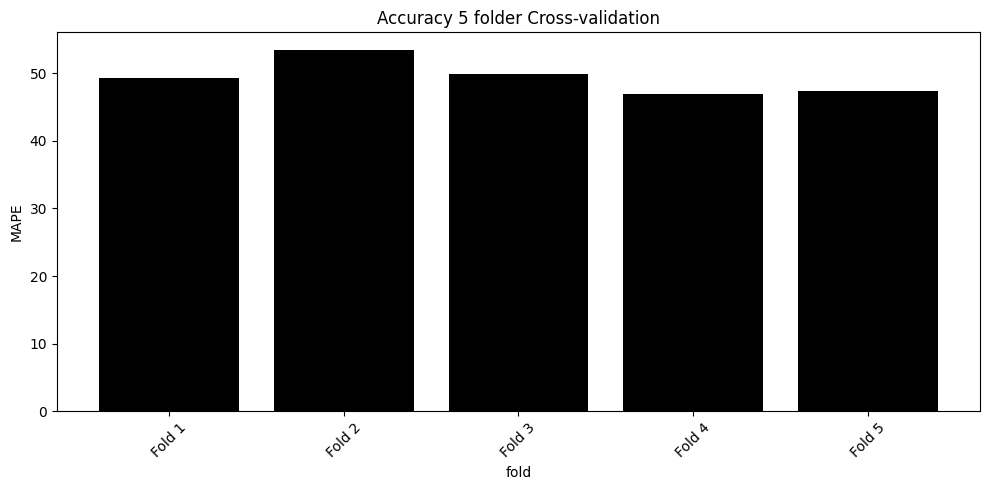

In [41]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='sigmoid'), regressor_name="SVR")

### Multivariable regression

In [42]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

Coefficients: [-2274.52418342  4623.95853219 -2170.29305868 ...  4757.7169161
     0.         -4027.8732934 ]
Intercept: 48754.9455872235


In [43]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

MAE: 3687.682931968947 
 MSE: 35134198.22289858 
 RMSE: 5927.410751997754 
 R2: 0.925414732504372 
 MAPE: 10.451273830853761
Mean: 3687.682931968947
Variance: 21535192.81616349
Standard Deviation: 4640.602635020961
r2_adjusted: 1.0204656591032417


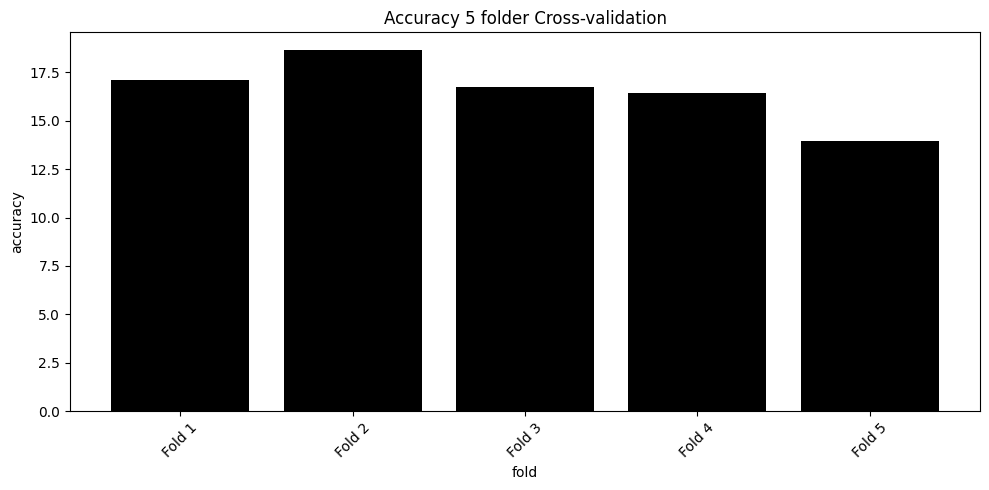

In [44]:
Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name="Lineal Regression")
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
cv_scores = -cross_val_score(linear_regressor, X_test, y_test, cv=5, scoring=mape_scorer)
Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="accuracy")

In [45]:
result

,Real,Prediction,diff
idx,,,
34583,57900,57671.127394,228.872606
151019,33800,36486.899510,-2686.899510
40752,78300,71469.805856,6830.194144
13609,34985,40352.895256,-5367.895256
68390,16900,18238.406790,-1338.406790
...,...,...,...
66387,105900,148961.075700,-43061.075700
7560,38300,30858.213894,7441.786106
25347,49890,53657.475311,-3767.475311


### ANN

In [46]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))


c:\Users\marti\Desktop\asignaturas\machineLearning\Cars_Price_Prediction\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [48]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 1754005888.0000 - mae: 36613.4492 - val_loss: 1945005312.0000 - val_mae: 38398.3516
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1774481792.0000 - mae: 36870.9648 - val_loss: 1868995456.0000 - val_mae: 37560.9336
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1592388480.0000 - mae: 34707.2617 - val_loss: 1309038336.0000 - val_mae: 30861.9473
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 940375296.0000 - mae: 25017.0840 - val_loss: 180038848.0000 - val_mae: 8760.6895
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 136776144.0000 - mae: 7380.4688 - val_loss: 114054240.0000 - val_mae: 6778.9346
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 85921904.0000 - mae: 5915.7031 - val_loss: 96970216.0000 - val_mae: 6321.9688
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 78124912.0000 - mae: 5552.5103 - val_loss: 84819264.0000 - val_mae: 5810.0889
Epoch 8/100
37/37

In [49]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

62/62 - 0s - 2ms/step - loss: 28415498.0000 - mae: 3441.4792
Mean Absolute Error on test set: 3441.48


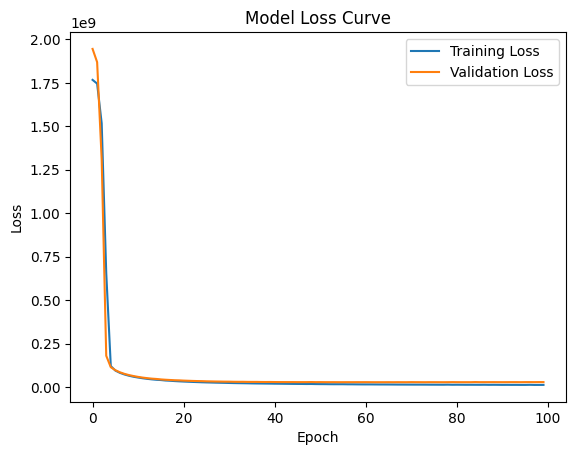

In [50]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [51]:
y_pred = model.predict(X_test).flatten()

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [52]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=len(electric_cars_encoded.columns), regressor_name="ANN")

MAE: 3441.47900390625 
 MSE: 28415500.732352618 
 RMSE: 5330.619169698077 
 R2: 0.9396776556968689 
 MAPE: 9.460494714159077
Mean: 3441.478934292846
Variance: 16571723.477171198
Standard Deviation: 4070.838178701187
r2_adjusted: 1.0165520159177364


,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(30875.6, 0.0]",2091.534126,4.246352e+06,2060.667913,19629.525391,0.583984,830
1,"(61751.2, 30875.6]",3514.510722,1.021235e+07,3195.676028,23818.039062,3.714844,929
2,"(92626.79999999999, 61751.2]",6437.639891,3.149620e+07,5612.147303,30797.132812,144.851562,149
3,"(123502.4, 92626.79999999999]",10481.496162,4.634606e+07,6807.793789,28571.937500,93.414062,57


In [53]:
Evaluator.save("electric_plug")

Regression results saved to: evaluation/electric_plug_regression.tex
Classification results saved to: evaluation/electric_plug_classification.tex


In [34]:
master = MasterGenerator(X=electric_cars_encoded.drop(columns=["price_categ"]), y_categ=target["price_categ"], y_numeric=target["price_categ"], n_tries=128, CUML=True, name="HP_electric_and_plugin")

KeyError: "['price_categ'] not found in axis"

In [53]:
kmeans_params = {
    "n_clusters": 4,
    "init": "k-means++",
    "n_init": 90,
    "max_iter": 200
}

agglomerative_params = {
    "n_clusters": 4,
    "linkage": "ward",
    "affinity": "euclidean"
}

dbscan_params = {
    "eps": 0.5,
    "min_samples": 5
}




# Clustering

In [54]:
cluster_gen = ClusterGenerator(electric_cars_encoded, use_cuml=False)



result = cluster_gen.custom_clustering("kmeans", **kmeans_params)


print("Labels:", result["labels"])
print("Metrics:", result["metrics"])



Labels: [3 2 1 ... 3 3 3]
Metrics: {'silhouette_score': 0.18082808320065483, 'calinski_harabasz_score': 1526.863854481121, 'davies_bouldin_score': 1.6530266155509927}
